# Hackathon MKB 2021

В данном нотебуке показан пример правильного файла с ответами для отправки на проверку.

##  Подготовка данных

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Скачиваем обучющую выборку
!wget https://github.com/dsbattle/hackathon-mkb/raw/master/train_dataset_hackathon_mkb.csv
!wget https://github.com/dsbattle/hackathon-mkb/raw/master/test_dataset_hackathon_mkb.csv

--2021-11-30 19:01:31--  https://github.com/dsbattle/hackathon-mkb/raw/master/train_dataset_hackathon_mkb.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dsbattle/hackathon-mkb/master/train_dataset_hackathon_mkb.csv [following]
--2021-11-30 19:01:31--  https://raw.githubusercontent.com/dsbattle/hackathon-mkb/master/train_dataset_hackathon_mkb.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9253323 (8.8M) [text/plain]
Saving to: ‘train_dataset_hackathon_mkb.csv.3’

train_dataset_hacka 100%[===================>]   8.82M  --.-KB/s    in 0.08s   

2021-11-30 19:01:31 (117 MB/s) - ‘train_

In [ ]:
train = pd.read_csv('train_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
print(f'Размер обучающей выборки: {train.shape}')
train.head()

Размер обучающей выборки: (17891, 124)


,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,...,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,...,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,...,1.0,1.0,36.00.2,6.0,2762852.0,1.0,794.0,3.0,21.0,5408695.0,39.0,882647.0,4.0,1.0,0.0,1.0,1.0,1174998.0,2.0,0.0,2.0,2.0,2738217.0,38.0,0.0,38.0,39.0,4209963.0,169.0,0.0,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,356828000.0,38078000.0,5.786965e+09,12001000.0,71000.0,1.232486e+09,78603000.0,4.459193e+09,4611000.0,2.685905e+09,1.516514e+09,NaN,NaN,65834000.0,1.103557e+09,627253000.0,NaN,689000.0,626564000.0,4.411295e+09,3.930000e+05,3.092581e+09,NaN,NaN,7.724453e+09,7.724453e+09,1.694054e+10,4.028466e+10,2.334412e+10,931118000.0,...,1.0,1.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test = pd.read_csv('test_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
print(f'Размер тестовой выборки: {train.shape}')
test.head()

Размер тестовой выборки: (17891, 124)


,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,...,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,17892,3620,08APR2019:00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17893,4101,08APR2019:00:00:00,0,1906000.0,NaN,1906000.0,NaN,NaN,NaN,NaN,14838000.0,4392000.0,NaN,727000.0,NaN,9719000.0,NaN,15222000.0,150000.0,NaN,NaN,NaN,15072000.0,NaN,NaN,NaN,NaN,1522000.0,NaN,1522000.0,NaN,NaN,16744000.0,16744000.0,2998000.0,310151000.0,307153000.0,2998000.0,NaN,...,2.0,2.0,46.3,2.0,0.0,0.0,0.0,0.0,7.0,4726558.0,0.0,0.0,0.0,181.0,0.0,77.0,47.0,17883526.0,1182.0,14.0,589.0,533.0,169299901.0,1204.0,2.0,857.0,767.0,138194657.0,10240.0,69.0,7439.0,7100.0,1.187411e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17894,9589,08APR2019:00:00:00,0,147000.0,NaN,147000.0,NaN,NaN,NaN,NaN,95529000.0,29812000.0,7000.0,56538000.0,504000.0,8430000.0,238000.0,4145000.0,2538000.0,NaN,NaN,NaN,1607000.0,NaN,NaN,NaN,NaN,91531000.0,NaN,91531000.0,NaN,NaN,95676000.0,95676000.0,48975000.0,506023000.0,457048000.0,1753000.0,47222000.0,...,1.0,1.0,33.12,10.0,2272145.0,2.0,176875.0,0.0,103.0,27542049.0,14.0,1743130.0,2.0,31.0,2.0,14.0,11.0,3681170.0,177.0,24.0,73.0,63.0,46085424.0,36.0,10.0,7.0,7.0,2375210.0,764.0,50.0,362.0,344.0,9.836260e+07,NaN,1.0,3.0,NaN,NaN,NaN,NaN
3,17895,11546,08APR2019:00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1906000.0,304000.0,NaN,682000.0,NaN,920000.0,NaN,1038000.0,NaN,NaN,NaN,NaN,NaN,95000.0,95000.0,NaN,NaN,774000.0,NaN,774000.0,NaN,NaN,1907000.0,1907000.0,NaN,9793000.0,8731000.0,1062000.0,NaN,...,1.0,1.0,52.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17896,12558,08APR2019:00:00:00,0,26000.0,NaN,NaN,NaN,26000.0,NaN,NaN,2735000.0,1324000.0,NaN,1410000.0,NaN,1000.0,NaN,1220000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1541000.0,179000.0,1362000.0,NaN,NaN,2761000.0,2761000.0,NaN,6407000.0,6301000.0,106000.0,NaN,...,2.0,2.0,43.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [ ]:
train_c = train.copy()
test_c = test.copy()

In [ ]:
import time

## Описание полей
Описание полей доступно по [ссылке](https://hackathon-mkb.ru/data/data_description.xlsx)

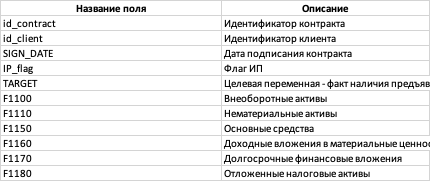

In [ ]:
lable_col = 'TARGET'
#features_cols = train.drop('TARGET', axis='columns').select_dtypes(include=[np.number]).columns.tolist()

In [ ]:
#считаем количество контрактов в день от одного пользователя
def calcCOUNTD(train, test):
  train, test = train.copy(), test.copy()

  df = pd.concat([train.drop(columns=['TARGET']), test])


  df["COUNT_D"]=1

  df[["id_client", "SIGN_DATE", "COUNT_D"]].groupby(["id_client", "SIGN_DATE"]).sum()

  train = train.merge(df[["id_client", "SIGN_DATE", "COUNT_D"]].groupby(["id_client", "SIGN_DATE"]).sum(), on=["id_client", "SIGN_DATE"], how="left")
  test = test.merge(df[["id_client", "SIGN_DATE", "COUNT_D"]].groupby(["id_client", "SIGN_DATE"]).sum(), on=["id_client", "SIGN_DATE"], how="left")
  return (train, test)



In [ ]:
def parseData(s):
    if(isinstance(s, str)==False):
      return 0
    day = s[:2]
    mon = s[2:5]
    year=s[5:9]
    lm = ["JAN", "FEB", "MAR", "APR", "MAY","JUN","JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

    mon = lm.index(mon)+1
    day = int(day[1])  if(day[0]=='0') else int(day)
    year = int(year)
    st = time.struct_time(
    (year, mon, day,0,0,0,0,0,0)
    )
    return time.mktime(st)
#счиатем количество контрактов, которые были у клиента до этого контракта
def calcCOUNT(train, test):
  train, test = train.copy(), test.copy()

  df = pd.concat([train.drop(columns=['TARGET']), test])
  df["TIME"] = df["SIGN_DATE"].apply(parseData)

  l=[]
  id_cont = []
  for x in df.groupby(["id_client"]):
    dff = x[1]
    count = 1
    for id, y in zip(dff["id_contract"], dff["TIME"]):
      id_cont.append(id)
      l.append(count)
      count += 1


  train = train.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "COUNT":l}), how="left", on = "id_contract")
  test = test.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "COUNT":l}), how="left", on = "id_contract")
  
  
  return train, test

In [ ]:
import time 

#считаем сколько времени прошло с момента последнего контракта
def calcDIFFTIME(train, test):
  train, test = train.copy(), test.copy()


  df = pd.concat([train.drop(columns=['TARGET']), test])


  df["TIME"] = df["SIGN_DATE"].apply(parseData)

  l=[]
  id_cont = []
  for x in df.groupby(["id_client"]):
    dff = x[1]
    prev = -1
    for id, y in zip(dff["id_contract"], dff["TIME"]):
      id_cont.append(id)
      if(y==0):
        l.append(-2)
        continue

      if(prev != y):
        if(prev==-1):
          l.append(-1)
          prev = y
        else:
          l.append(y-prev)
          prev = y
      else:
        l.append(l[-1])

  train = train.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "DIFF_TIME":l}), how="left", on = "id_contract")
  test = test.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "DIFF_TIME":l}), how="left", on = "id_contract")
  return train, test

In [ ]:
#бывает что клиент заключает больше одного контракта в день.
#считаем сколько времени прошло с последнего такого "мультиконтракта"
def calcDIFFTIMEmultic(train, test):
  train, test = train.copy(), test.copy()


  df = pd.concat([train.drop(columns=['TARGET']), test])


  df["TIME"] = df["SIGN_DATE"].apply(parseData)

  l=[]
  id_cont = []
  for x in df.groupby(["id_client"]):
    dff = x[1]
    prev = -1
    prevd = -1
    for id, y, z in zip(dff["id_contract"], dff["TIME"], dff["COUNT_D"]):
      id_cont.append(id)
      if(y==0):
        l.append(-2)
        continue

      if(prev != y):
        if(prev==-1):
          l.append(-1)
        else:
          l.append(y-prev)
        
        if(z>1):
          prev = y
      else:
        l.append(l[-1])



  train = train.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "DIFF_TIME_multic":l}), how="left", on = "id_contract")
  test = test.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "DIFF_TIME_multic":l}), how="left", on = "id_contract")
  return train, test

In [ ]:
#считаем сколько времени в среднем проходило между контрактами до это контракта
def calcDIFFTIMEMEAN(train, test):
  train, test = train.copy(), test.copy()


  df = pd.concat([train.drop(columns=['TARGET']), test])


  df["TIME"] = df["SIGN_DATE"].apply(parseData)

  l=[]
  id_cont = []
  for x in df.groupby(["id_client"]):
    dff = x[1]
    cm = 0
    n = 0
    prev = -1
    for id, y, t in zip(dff["id_contract"], dff["DIFF_TIME"], dff["TIME"]):
      id_cont.append(id)
      if(y==-1):
        l.append(0)
        continue

      if(y==-2):
        l.append(-1)
        continue

      if(t!=prev):
        cm = cm*(n/(n+1)) + y/(n+1)
        n += 1
        l.append(cm)
      else:
        l.append(l[-1])
        
      prev=t

  train = train.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "DIFF_TIME_mean":l}), how="left", on = "id_contract")
  test = test.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "DIFF_TIME_mean":l}), how="left", on = "id_contract")
  return train, test

In [ ]:
#бывает что у ип есть юр лицо. Флаг равен единице если до этого мы видели клиента и как юр лицр и как ип
def CALCIPMEAN(train, test):
  train, test = train.copy(), test.copy()

  df = pd.concat([train.drop(columns=['TARGET']), test])

  train, test = train.copy(), test.copy()


  df = pd.concat([train.drop(columns=['TARGET']), test])


  df["TIME"] = df["SIGN_DATE"].apply(parseData)

  l=[]
  id_cont = []
  for x in df.groupby(["id_client"]):
    dff = x[1]
    cm = 0
    n = 0 
    for id, y in zip(dff["id_contract"], dff["IP_flag"]):
      id_cont.append(id)
      cm = cm*(n/(n+1)) + y/(n+1)
      n += 1
      l.append(1 if 0.0 < cm < 1.0 else 0)


  train = train.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "IP_mean":l}), how="left", on = "id_contract")
  test = test.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "IP_mean":l}), how="left", on = "id_contract")
  return train, test



In [ ]:
#сколько контрактов было в ближайшем "мультиконтракте"
def calcMULTIC(train, test):

  train, test = train.copy(), test.copy()

  df = pd.concat([train.drop(columns=['TARGET']), test])


  df["TIME"] = df["SIGN_DATE"].apply(parseData)

  l=[]
  id_cont = []
  for x in df.groupby(["id_client"]):
    dff = x[1]
    fl = 0
    prevt = -1

    for id, y, z in zip(dff["id_contract"], dff["TIME"], dff["COUNT_D"]):
      id_cont.append(id)

      if(y != prevt):
        l.append(fl)
        if(z>1):
          fl=z
        prevt = y
      else:
        l.append(l[-1])

  train = train.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "MULTIC":l}), how="left", on = "id_contract")
  test = test.merge(pd.DataFrame.from_dict({"id_contract":id_cont, "MULTIC":l}), how="left", on = "id_contract")
  return train, test


In [ ]:
#Сколько раз контракт клиент встретился во всем датасете. Здесь вожможно есть заглядывание в будущее поэтому фича отключается по флагу в дальнейшем
def calcCOUNT2(train, test):
  train, test = train.copy(), test.copy()

  df = pd.concat([train.drop(columns=['TARGET']), test])

  df["COUNT"]=1

  df = df[["id_client", "COUNT"]].groupby("id_client").sum()

  return train.merge(df, how="left", on="id_client"), test.merge(df, how="left", on="id_client")



In [ ]:
def applyCommonTransforms(train, test, fair = True):
  if(fair):
    ct = [calcCOUNT, calcDIFFTIME, calcCOUNTD,calcDIFFTIMEMEAN,CALCIPMEAN, calcDIFFTIMEmultic, calcMULTIC]
  else:
    ct = [calcCOUNT2, calcDIFFTIME, calcCOUNTD,calcDIFFTIMEMEAN,CALCIPMEAN, calcDIFFTIMEmultic, calcMULTIC]

  for f in ct:
    train, test = f(train, test)
  return train, test

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict

#простой парсинг числовых фичей
class SimpleRealExtractor(BaseEstimator, TransformerMixin):
  def __init__(self):
    default_value = {}
    d = {}
    self.defaults = defaultdict(lambda:-1, d)
    self.throw = set(['OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_CODE', 'OKTMO_FED', "id_client", "id_contract"])
    self.add = []

  def fit(self, X, y = None):
    trow = set([])
    features_cols = X.drop('TARGET', axis='columns').select_dtypes(include=[np.number]).columns.tolist()
    features_cols = [x for x in  features_cols if x not in self.throw]
    features_cols = features_cols + self.add
    self.features_cols = features_cols
    return self

  def transform(self, X, y = None):
    X = X.copy()
    for f in self.features_cols:
      X[f] = X[f].fillna(self.defaults[f])

    return X[self.features_cols] #.values.tolist()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
#one hot кодирование категориальных
class SimpleCategorialExtractor(BaseEstimator, TransformerMixin):
  def __init__(self):
    default_value = {}
    d = {}
    self.defaults = defaultdict(lambda:"Nan", d)
    self.throw = set(['SIGN_DATE', 'DATEFIRSTREG', 'TAXREG_REGDATE','TAXREGPAY_REGDATE', 'OKVED_CODE', 'BIRTHDATE'])
    self.add =['OKATO_REGIONCODE', 'OKATO_FED',  'OKTMO_FED'] #[]# [ 'OKATO_FED',  'OKTMO_FED'] #'OKTMO_CODE', many values
    #self.add = []

    self.oh = OneHotEncoder(handle_unknown='ignore')

  def fit(self, X, y = None):
    X = X.copy()
    trow = set([])
    features_cols = X.drop('TARGET', axis='columns').select_dtypes(include=[object]).columns.tolist()
    features_cols = [x for x in  features_cols if x not in self.throw]
    features_cols = features_cols + self.add
    self.features_cols = features_cols

    for f in self.features_cols:
      X[f] = X[f].fillna(self.defaults[f]).apply(str)


    vals = X[self.features_cols].values.tolist()

    self.oh.fit(vals)
    return self

  def transform(self, X, y = None):
    X = X.copy()
    for f in self.features_cols:
      X[f] = X[f].fillna(self.defaults[f]).apply(str)
    vals = X[self.features_cols].values.tolist()
    
    df = self.oh.transform(vals).todense().tolist()

    cols = []
    for znach, name in zip(self.oh.categories_, self.features_cols):
      for z in znach:
        cols.append(name + ":" + z)

    return pd.DataFrame(df, columns=cols)

In [ ]:
def get1OKVED(s):
  if(s.count(".") == 0) and (not s.isdigit()):
    return "No"
  else:
    return s.split('.')[0]

def get2OKVED(s):
  if(s.count(".") < 1):
    return "No"
  else:
    return s.split('.')[1]

#бьем оквед на подгруппы и кодируем one hot
class OKVEDExtractor(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.oh = OneHotEncoder(handle_unknown='ignore')

  def fit(self, X, y = None):
    vals = [[x, y] for x, y in zip(X["OKVED_CODE"].apply(str).apply(get1OKVED).tolist(), X["OKVED_CODE"].apply(str).apply(get2OKVED).tolist())]
    self.oh.fit(vals)
    return self

  def transform(self, X, y = None):
    vals = [[x, y] for x, y in zip(X["OKVED_CODE"].apply(str).apply(get1OKVED).tolist(), X["OKVED_CODE"].apply(str).apply(get2OKVED).tolist())]
    
    df = self.oh.transform(vals).todense().tolist()

    cols = []
    for i, znach in enumerate(self.oh.categories_):
      for z in znach:
        cols.append("OKVED:" + str(i)+":" + z)

    return pd.DataFrame(df, columns=cols )

In [ ]:
#one hot частотных клиентов
class BestClientExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, test):
    self.threshold = 5
    self.test_id = set(test.id_client)

  def fit(self, X, y = None):
    series = X["id_client"].value_counts()
    ids = []
    for x in series.index:
      if (series[x]>self.threshold)and(x in self.test_id):
        ids.append(x)
    self.good_ids = set(ids)

    vals = []
    for x in X["id_client"]:
      if(x in self.good_ids):

        vals.append([str(x)])
      else:
        vals.append(['None'])
    #print(ids)
    self.oh = OneHotEncoder(handle_unknown='ignore', categories = [[str(x) for x in ids]])
    self.oh.fit(vals)
    return self

  def transform(self, X, y = None):
    vals = []
    for x in X["id_client"]:
      if(x in self.good_ids):

        vals.append([str(x)])
      else:
        vals.append(['None'])
    df= self.oh.transform(vals).todense().tolist()

    cols = []
    for i, znach in enumerate(self.oh.categories_):
      for z in znach:
        cols.append("CLIENT:" + z)


    return pd.DataFrame( df, columns=cols )

In [ ]:
#one hot частотных октмо
class OKTMOExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, test, fair = True):
    if(not fair):
      self.oh = OneHotEncoder(handle_unknown='ignore')

    self.threshold = 5
    self.test_id = set(test.OKTMO_CODE)
    self.fair = fair

  def fit(self, X, y = None):
    if(self.fair):
      series = X.drop(columns=["id_contract", "SIGN_DATE"]).drop_duplicates()["OKTMO_CODE"].value_counts()
    else:
      series = X["OKTMO_CODE"].value_counts()


    oktmo = []
    for x in series.index:
      if (series[x]>self.threshold)and(x in self.test_id):
        oktmo.append(x)
    self.good_oktmo = set(oktmo)

    vals = []
    for x in X["OKTMO_CODE"]:
      if(x in self.good_oktmo):

        vals.append([str(x)])
      else:
        vals.append(['None'])

    if(self.fair):
      self.oh = OneHotEncoder(handle_unknown='ignore', categories = [[str(x) for x in oktmo]])

    self.oh.fit(vals)
    return self

  def transform(self, X, y = None):
    vals = []
    for x in X["OKTMO_CODE"]:
      if(x in self.good_oktmo):

        vals.append([str(x)])
      else:
        vals.append(['None'])
    df = self.oh.transform(vals).todense().tolist()

    cols = []
    for i, znach in enumerate(self.oh.categories_):
      for z in znach:
        cols.append("OKTMO:" + z)

    return pd.DataFrame(df, columns=cols)


In [ ]:
#из октмо кода можно достать тип населенного пункта из котрого клиента
#из аула ркгионального центра или областного города и тд
def parse_oktmo(cod):
  if(cod == "nan"):
    return "nan","nan", "nan","nan","nan"

  cod = cod[:-2]
  if(len(cod)==10):
    cod = cod[1:]
  else:
    cod = cod[2:]
  P3, CP3, cod = cod[0], cod[1:3], cod[3:]

  if(P3=="8")or(P3=="9"):
    if("10" <= CP3 <= "29"):
      CP3="1"
    elif("30" <= CP3 <= "49"):
      CP3="2"
    elif("50" <= CP3 <= "98"):
      CP3="3"
    else:
      CP3="4"
  else:
    CP3="0"
  
  P6, CP6, cod = cod[0], cod[1:3], cod[3:]

  if(P6=="1"):
    if("01" <= CP6 <= "49"):
      CP6="1"
    elif("50" <= CP6 <= "99"):
      CP6="2"
    else:
      CP6="3"
  else:
    CP6="0"

  if(cod in set(["001", "051", "101"])):
    pass
  else:
    if("001" <= CP6 <= "049"):
      cod="002"
    elif("051" <= CP6 <= "099"):
      cod="52"
    elif("101" <= CP6 <= "999"):
      cod="102"
    else:
      cod="0"

  return P3, P6, CP3, CP6, cod 

class OKTMOExtractorNew(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.oh = OneHotEncoder(handle_unknown='ignore')

  def fit(self, X, y = None):
    vals = X["OKTMO_CODE"].apply(str).apply(parse_oktmo).tolist()
    #print(vals)
    self.oh.fit(vals)
    return self

  def transform(self, X, y = None):
    vals = X["OKTMO_CODE"].apply(str).apply(parse_oktmo).tolist()
    df = self.oh.transform(vals).todense().tolist()

    cols = []
    for i, znach in enumerate(self.oh.categories_):
      for z in znach:
        cols.append("OKTMONEW:" + str(i)+":" + z)

    return pd.DataFrame(df, columns=cols )




In [ ]:
#кодируем время количеством секунд с начала unix эпохи
import time 
def parseData(s):
  if(isinstance(s, str)==False):
    return 0
  day = s[:2]
  mon = s[2:5]
  year=s[5:9]
  lm = ["JAN", "FEB", "MAR", "APR", "MAY","JUN","JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

  mon = lm.index(mon)+1
  day = int(day[1])  if(day[0]=='0') else int(day)
  year = int(year)
  st = time.struct_time(
  (year, mon, day,0,0,0,0,0,0)
  )
  return time.mktime(st)

class TimeExctractor(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.features_cols=[ 'DATEFIRSTREG', 'TAXREG_REGDATE','TAXREGPAY_REGDATE', 'BIRTHDATE']

  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X = X.copy()
    for f in self.features_cols:
      X[f] = X[f].apply(parseData)
    
    return X[self.features_cols]


In [ ]:
#решение с неоднозначной фичей
train, test = train_c.copy(), test_c.copy()
train, test = applyCommonTransforms(train, test, fair=False)

In [ ]:
#train = train.drop(columns=["COUNT"]).merge(train[["id_client", "SIGN_DATE", "COUNT"]].groupby(["id_client", "SIGN_DATE"]).max().reset_index(), on=["id_client", "SIGN_DATE"], how = "left")
#test = test.drop(columns=["COUNT"]).merge(test[["id_client", "SIGN_DATE", "COUNT"]].groupby(["id_client", "SIGN_DATE"]).max().reset_index(), on=["id_client", "SIGN_DATE"], how = "left")

## validation

In [ ]:
from sklearn.pipeline import FeatureUnion

In [ ]:

val_size = int(len(train)*0.33)

X_tr = train.iloc[:len(train)-val_size]
X_te = train.iloc[len(train)-val_size:]


y_train = X_tr["TARGET"]
y_val = X_te["TARGET"]


In [ ]:
transformer_list = [("SimpleReal", SimpleRealExtractor() ),
                      ("SimpleCat", SimpleCategorialExtractor() ),
                      ("OKVED", OKVEDExtractor()), #,
                      ("Good Client", BestClientExtractor(X_te) ),
                      ("Good regions", OKTMOExctractor(X_te, fair=False) ),
                      ("regions new code", OKTMOExtractorNew() ),
                      ("Time", TimeExctractor())
                      ]
                    
union = FeatureUnion(transformer_list)

In [ ]:
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
X_train = union.fit_transform(X_tr)
X_test = union.transform(X_te)

clf = LGBMClassifier(n_estimators=100)
clf.fit(X_train, y_train)
roc_auc_score(y_val, clf.predict_proba(X_test)[:,1] )

0.9624404713646764

In [ ]:
all_features = []
for n, t in transformer_list:
  all_features += list(t.fit_transform(train).columns.values)

In [ ]:
def parseMonth(s):
  if(isinstance(s, str)==False):
    return 0
  day = s[:2]
  mon = s[2:5]
  year=s[5:9]
  lm = ["JAN", "FEB", "MAR", "APR", "MAY","JUN","JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

  mon = lm.index(mon)+1
  day = int(day[1])  if(day[0]=='0') else int(day)
  year = int(year)
  st = time.struct_time(
  (year, mon, day,0,0,0,0,0,0)
  )
  return str(year) + '_' + (str(mon) if len(str(mon))==2 else '0'+ str(mon))


def custom_cv(train):
  MONTH = ['2018_11', '2018_12', '2019_01', '2019_02', '2019_03', '2019_04']
  for i in range(0,5):
    M = MONTH[i:]
    yield (train[~train.SIGN_DATE.apply(parseMonth).isin(M)].index.values, train[train.SIGN_DATE.apply(parseMonth).isin(M[:])].index.values)

In [ ]:
X_full_train = union.fit_transform(train)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
cv = cross_val_score(LGBMClassifier(n_estimators=100), X_full_train, train.TARGET.values, cv=custom_cv(train), scoring='roc_auc', n_jobs = 5)



In [ ]:
cv, cv.mean()

(array([0.9608006 , 0.96635374, 0.97052375, 0.96577507, 0.95044123]),
 0.9627788796936751)

## on all train

In [ ]:
clf = LGBMClassifier(n_estimators=1500, learning_rate=0.01)

In [ ]:
transformer_list = [("SimpleReal", SimpleRealExtractor() ),
                      ("SimpleCat", SimpleCategorialExtractor() ),
                      ("OKVED", OKVEDExtractor()), #,
                      ("Good Client", BestClientExtractor(test) ),
                      ("Good regions", OKTMOExctractor(test, fair=False) ),
                      ("regions new code", OKTMOExtractorNew() ),
                      ("Time", TimeExctractor())
                      ]
union = FeatureUnion(transformer_list)
X_full_train = union.fit_transform(train)
clf.fit(X_full_train, train.TARGET.values)

LGBMClassifier(learning_rate=0.01, n_estimators=1500)

In [ ]:
ypred = clf.predict_proba(union.transform(test))[:, 1]

## Features discussion

SyntaxError: ignored

Общей список фичей отсортированных по важности приведен ниже.   
В фичах из оригинального датасета можно найти достаточно простую зависимость.  
Чем у фирмы больше денег, чем она дольше существует, чем она больше, тем больше шанс что она выполнит контрак.  
Сгенерированные мной фичи(за исключенением октмо) отражают общую контрактную нагрузку. Чем она больше тем, меньше шанс, что фирма контракты выполнит.  
Топ придуманных мной фитчей:  
1)общее количество контрактов.  Контрактная нагрузка  
2)количество контрактов в день.  
3)время до предыдущего "мультиконтракта"(фирма заключала больше контракта в день).  
Я не работаю в этой области и мне трудно судить, почему так происходит, но если фирма заключает больше контракта в день. То меньше шанс что она выполнит их и остальные.
Не для всех областей это плохо(для туризма если смотреть на первое дерево бустинга это не так), но для большинства.
Чем больше времени прошло с "мультиконтракта", тем лучше

4)Время до ближайшего контракта   
5)Среднее время между контрактами.  
Третий контрак за год и третий контракт за месяц это разная нагрузка. И эти фичи помогают их различить  

6)Если у ип есть юр лицо, то видимо это крепкий хозяйственник и он выполняет контракты. Средний таргет таких клиентов близок к нулю

7) Тип области из котрой клиент. Парсится из октмо. Из крупного центра лучше чем из аула.  

Экономический смысл ориганальных фичей должен быть лучше известен организаторам.
Плолный список отсортированный по важности ниже

In [ ]:
all_features = []
for n, t in transformer_list:
  all_features += list(t.fit_transform(train).columns.values)

l = list(zip(clf.feature_importances_, all_features))
l.sort(key=lambda a: -a[0])
l

[(2297, 'COUNT'),
 (1282, 'DATEFIRSTREG'),
 (1033, 'TELEPHONECOUNT'),
 (851, 'F1250'),
 (706, 'TAXREG_REGDATE'),
 (682, 'WINNERNUMBER_95_EVER'),
 (677, 'DIFF_TIME'),
 (656, 'F1300'),
 (647, 'COUNT_D'),
 (634, 'F1230'),
 (619, 'DIFF_TIME_mean'),
 (575, 'F1210'),
 (557, 'OKVED:0:No'),
 (537, 'MANAGERCOUNTINCOUNTRY'),
 (532, 'SUM_95_YEAR'),
 (519, 'ADMITTEDNUMBER_95_EVER'),
 (518, 'F2350'),
 (508, 'DIFF_TIME_multic'),
 (486, 'ADMITTEDNUMBER_95_YEAR'),
 (478, 'F2200'),
 (462, 'F2400_LAG1'),
 (446, 'OKVED:0:46'),
 (417, 'F2110'),
 (410, 'F2410'),
 (408, 'MANAGERINNCOUNT'),
 (399, 'F2340'),
 (379, 'F2400'),
 (363, 'F2120_LAG1'),
 (361, 'WINNERNUMBER_95_YEAR'),
 (358, 'F1520'),
 (358, 'BIRTHDATE'),
 (357, 'SUM_95_EVER'),
 (352, 'F1520_LAG1'),
 (352, 'F2200_LAG1'),
 (347, 'F1100'),
 (343, 'F2100'),
 (342, 'TAXREGPAY_REGDATE'),
 (340, 'SIGNEDNUMBER_95_EVER'),
 (340, 'OKVED:1:46'),
 (338, 'F2120'),
 (337, 'F1500'),
 (336, 'NOTADMITTEDNUMBER_EVER'),
 (332, 'DEFENDANT_SUM_EVER'),
 (327, 'F1510'),


In [ ]:
test["TARGET"]=1

In [ ]:
#заменяем клиентов без заполненных полей на нули. Зависимость из трэйна
X = test.drop(columns=[ 'id_contract', 'SIGN_DATE', 'IP_flag', "id_client", "DIFF_TIME", "DIFF_TIME_mean", "IP_mean", "MULTIC", "COUNT_D", "DIFF_TIME_multic", "COUNT", "TARGET"]).values
#"TIME"
col = []
for i in range(X.shape[0]):
  line = []
  for j in range(X.shape[1]):
    try:
        line.append(np.isnan(X[i,j]))
    except TypeError:
        line.append(False)
  col.append(all(line))

ypred[col] = 0
test['TARGET'] = ypred.tolist()
test[['id_contract', 'TARGET']].to_csv('submit_file.csv', sep=';', index=False)
test[['id_contract', 'TARGET']].head()

,id_contract,TARGET
0,17892,0.000000
1,17893,0.023120
2,17894,0.060916
3,17895,0.332837
4,17896,0.949792


## Решение без неоднозначных фичей




In [ ]:
train, test = train_c.copy(), test_c.copy()
train, test = applyCommonTransforms(train, test, fair=True)

In [ ]:
train = train.drop(columns=["COUNT"]).merge(train[["id_client", "SIGN_DATE", "COUNT"]].groupby(["id_client", "SIGN_DATE"]).max().reset_index(), on=["id_client", "SIGN_DATE"], how = "left")
test = test.drop(columns=["COUNT"]).merge(test[["id_client", "SIGN_DATE", "COUNT"]].groupby(["id_client", "SIGN_DATE"]).max().reset_index(), on=["id_client", "SIGN_DATE"], how = "left")

In [ ]:
clf = LGBMClassifier(n_estimators=1500, learning_rate=0.01)
transformer_list = [("SimpleReal", SimpleRealExtractor() ),
                      ("SimpleCat", SimpleCategorialExtractor() ),
                      ("OKVED", OKVEDExtractor()), #,
                      ("Good Client", BestClientExtractor(train) ),
                      ("Good regions", OKTMOExctractor(train, fair=True) ),
                      ("regions new code", OKTMOExtractorNew() ),
                      ("Time", TimeExctractor())
                      ]
union = FeatureUnion(transformer_list)
X_full_train = union.fit_transform(train)
clf.fit(X_full_train, train.TARGET.values)

ypred = clf.predict_proba(union.transform(test))[:, 1]

test["TARGET"]=1
X = test.drop(columns=[ 'id_contract', 'SIGN_DATE', 'IP_flag', "id_client", "DIFF_TIME", "DIFF_TIME_mean", "IP_mean", "MULTIC", "COUNT_D", "DIFF_TIME_multic", "COUNT", "TARGET"]).values
#"TIME"
col = []
for i in range(X.shape[0]):
  line = []
  for j in range(X.shape[1]):
    try:
        line.append(np.isnan(X[i,j]))
    except TypeError:
        line.append(False)
  col.append(all(line))

ypred[col] = 0
test['TARGET'] = ypred.tolist()
test[['id_contract', 'TARGET']].to_csv('submit_file_fair.csv', sep=';', index=False)
test[['id_contract', 'TARGET']].head()

,id_contract,TARGET
0,17892,0.000000
1,17893,0.018777
2,17894,0.122698
3,17895,0.319343
4,17896,0.963836
